In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import BertConfig, BertModel
import mteb
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, load_dataset_builder
from sklearn.model_selection import train_test_split
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import matplotlib as mpl


import pickle
import time
import memory_profiler
from tqdm.notebook import tqdm

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

2024-12-06 10:39:02.893763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 10:39:02.905536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733477942.917050   17457 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733477942.920643   17457 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 10:39:02.936056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# old one '1.8.1+cu111'
torch.__version__

'2.5.0+cu124'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import (
    fix_all_seeds,
    train_loop,
    train_loop_train_test_split,
    EmbeddingOnlyModel,
    train_loop_embedding_layer,
)
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
    SameSentencePairDataset,
)
from text_embeddings_src.embeddings import generate_embeddings, generate_embeddings_embed_layer
from text_embeddings_src.metrics import knn_accuracy


In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-12-06 10:39:44CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.28.0

transformers: 4.45.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

tqdm                 : 4.66.4
torch                : 2.5.0
mteb                 : 1.19.9
sklearn              : 1.5.2
transformers         : 4.45.2
matplotlib           : 3.9.2
numpy                : 1.26.4
jupyter_black        : 0.4.0
datasets             : 3.0.1
pandas               : 2.2.3
sentence_transformers: 3.3.0
black                : 24.10.0
distro               : 1.9.0
scipy                : 1.11.4
memory_profiler      : 0.61.0
text_embeddings_src  : 0.0.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Arxiv
180 classes (secondary labels)

In [ ]:
dataset_name = "arxiv"
dataset_path = "mteb/arxiv-clustering-p2p"

## Get dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("mteb/arxiv-clustering-p2p")

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 31
    })
})

In [ ]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels_secondary = list(
    np.hstack(dataset.data["test"].to_pandas().labels.to_numpy())
)

In [ ]:
labels_main = [elem.split(".")[0] for elem in labels_secondary]

In [ ]:
print("# samples", len(labels_secondary))
print("# classes (secondary)", len(np.unique(labels_secondary)))
print("# classes (main)", len(np.unique(labels_main)))

# samples 732723
# classes (secondary) 180
# classes (main) 39


In [ ]:
np.unique(labels_main)

array(['acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'astro-ph',
       'atom-ph', 'chao-dyn', 'chem-ph', 'cmp-lg', 'comp-gas', 'cond-mat',
       'cs', 'dg-ga', 'econ', 'eess', 'funct-an', 'gr-qc', 'hep',
       'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph',
       'mtrl-th', 'nlin', 'nucl-ex', 'nucl-th', 'other', 'patt-sol',
       'physics', 'plasm-ph', 'q-alg', 'q-bio', 'q-fin', 'quant-ph',
       'solv-int', 'stat', 'supr-con'], dtype='<U8')

## Baseline accs

### TF-IDF

In [ ]:
%%time

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(sentences)
print(tfidf_features.shape)

In [ ]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# # save results
# np.save(variables_path / "updated_dataset" / "svd_data", svd_data)

peak memory: 6361.34 MiB, increment: 2161.59 MiB
CPU times: user 21min 59s, sys: 30min 22s, total: 52min 22s
Wall time: 4min 34s


In [ ]:
%%time
%%memit

knn_accuracies_main = knn_accuracy(
    [tfidf_features, svd_data, normalize(svd_data, axis=1)],
    labels_main,
)
np.save(
    variables_path
    / "updated_dataset"
    / f"knn_accuracy_tfidf_svd_l2_{dataset_name}_main",
    knn_accuracies_main,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 76265.64 MiB, increment: 0.00 MiB
CPU times: user 3d 11h 58min 16s, sys: 7min 27s, total: 3d 12h 5min 43s
Wall time: 2h 41min 5s


In [ ]:
%%time
%%memit

knn_accuracies_secondary = knn_accuracy(
    # [svd_data, normalize(svd_data, axis=1)],
    [tfidf_features, svd_data, normalize(svd_data, axis=1)],
    labels_secondary,
)
np.save(
    variables_path
    / "updated_dataset"
    / f"knn_accuracy_tfidf_svd_l2_{dataset_name}_secondary",
    knn_accuracies_secondary,
)

peak memory: 7171.77 MiB, increment: 1056.76 MiB
CPU times: user 4d 12h 24min 4s, sys: 50.3 s, total: 4d 12h 24min 54s
Wall time: 5h 40min 39s


In [ ]:
knn_accuracies_main = np.load(
    variables_path
    / "updated_dataset"
    / f"knn_accuracy_tfidf_svd_l2_{dataset_name}_main.npy",
)

print(knn_accuracies_main)
print(knn_accuracies_secondary)

[0.74496745 0.70559415 0.71711272]
[0.44394252 0.39996998 0.4052243 ]


### Models

In [ ]:
model_names = [
    "MPNet",
    "SimCSE",
    "SBERT",
    "SPECTER",
    "SciNCL",
]

model_paths = [
    "microsoft/mpnet-base",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_names[i])

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # evaluation
    model.to(device)

    ## get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    ## run knn
    knn_accuracies_baseline_main = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels_main,
    )
    print(f"{model_name}: {knn_accuracies_baseline_main}")

    knn_accuracies_baseline_secondary = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels_secondary,
    )
    print(f"{model_name}: {knn_accuracies_baseline_secondary}")

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        f"updated_dataset/mteb_datasets/{dataset_name}"
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    np.save(
        variables_path / saving_path / "knn_accuracies_baseline_main",
        knn_accuracies_baseline_main,
    )
    np.save(
        variables_path / saving_path / "knn_accuracies_baseline_secondary",
        knn_accuracies_baseline_secondary,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SciNCL
Running on device: cuda


  0%|          | 0/2863 [00:00<?, ?it/s]

## Fine-tune MPNet (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
(
    losses,
    knn_accuracies_main,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels_main,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
    return_embeddings=True,
)


knn_accuracies_secondary = knn_accuracy(
    [
        embedding_av,
        embedding_cls,
        embedding_sep,
    ],
    labels_secondary,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_main",
    knn_accuracies_main,
)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_secondary",
    knn_accuracies_secondary,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 9h 31min 46s, sys: 4h 34min 37s, total: 14h 6min 24s
Wall time: 5h 40min 42s


In [ ]:
print(knn_accuracies_main)
print(knn_accuracies_secondary)

[array([0.74887066, 0.72209409, 0.73523672])]
[0.44231845 0.41610143 0.42875275]


#### Training only on train set
Only MPNet, crops

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels_secondary,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1_train_test_split", losses)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run1_secondary_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/15289 [00:00<?, ?it/s]

  0%|          | 0/2576 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

CPU times: user 8h 30min 49s, sys: 55min 58s, total: 9h 26min 48s
Wall time: 5h 6min 57s


In [ ]:
print(knn_accuracies)

[0.44126758833403845]


## Fine-tune MPNet (dropout)
Run 2, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
(
    losses,
    knn_accuracies_main,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels_main,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
    return_embeddings=True,
)


knn_accuracies_secondary = knn_accuracy(
    [
        embedding_av,
        embedding_cls,
        embedding_sep,
    ],
    labels_secondary,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2_main",
    knn_accuracies_main,
)
np.save(
    variables_path / saving_path / "knn_accuracies_run2_secondary",
    knn_accuracies_secondary,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 9h 32min 41s, sys: 4h 42min 47s, total: 14h 15min 28s
Wall time: 5h 41min 39s


In [ ]:
print(knn_accuracies_main)
print(knn_accuracies_secondary)

[array([0.70425668, 0.70055819, 0.70341053])]
[0.39919206 0.40286326 0.39939678]


#### Training only on train set
Only MPNet, Dropout, eval only for labels secondary

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels_secondary,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = SameSentencePairDataset(
    pd.Series(sentences_train),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run2_train_test_split", losses)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run2_secondary_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/15289 [00:00<?, ?it/s]

  0%|          | 0/2576 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

CPU times: user 8h 39min 50s, sys: 1h 2min 28s, total: 9h 42min 18s
Wall time: 5h 7min 17s


In [ ]:
print(knn_accuracies)

[0.3891474349351057]


## Fine-tune random BERT (crops)
Run 5, crop augmentations

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
(
    losses,
    knn_accuracies_main,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels_main,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
    return_embeddings=True,
)


knn_accuracies_secondary = knn_accuracy(
    [
        embedding_av,
        embedding_cls,
        embedding_sep,
    ],
    labels_secondary,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run5", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5_main",
    knn_accuracies_main,
)
np.save(
    variables_path / saving_path / "knn_accuracies_run5_secondary",
    knn_accuracies_secondary,
)


print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

In [ ]:
print(knn_accuracies_main)
print(knn_accuracies_secondary)

[array([0.72861764, 0.7220395 , 0.71355069]), array([0.73879874, 0.73306675, 0.7321933 ]), array([0.74343892, 0.73916722, 0.73784341]), array([0.74585454, 0.74252453, 0.74103694]), array([0.7475059 , 0.74270195, 0.74331609]), array([0.74974411, 0.74479003, 0.74536323]), array([0.75184584, 0.74539053, 0.74534958]), array([0.75024907, 0.74756049, 0.7472193 ]), array([0.75180489, 0.74731484, 0.7497714 ]), array([0.75281482, 0.74732848, 0.74897984])]
[0.44605789 0.44525269 0.44323284]


#### Training only on train set 
RandomBERT, Crops
With modified train loop to only evaluate after the 10 training epochs and not after each epoch

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels_secondary,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(       # Modified to evaluate only after the 10 training epochs, for runtime reasons
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run5_train_test_split", losses)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run5_secondary_train_test_split",
    knn_accuracies,
)

Model:  random_bert
Running on device: cuda


  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

In [ ]:
print(knn_accuracies)

[0.44734076672171197]


## Fine-tune random embedding layer (not module)

### Run 3, crop augmentations 1 epoch

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 57.1 ms, sys: 63.1 ms, total: 120 ms
Wall time: 392 ms


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
(
    losses,
    knn_accuracies_main,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels_main,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
    return_embeddings=True,
)


knn_accuracies_secondary = knn_accuracy(
    [
        embedding_av,
        embedding_cls,
        embedding_sep,
    ],
    labels_secondary,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_main",
    knn_accuracies_main,
)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_secondary",
    knn_accuracies_secondary,
)


print("----------------------------")

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

----------------------------
CPU times: user 5h 1min 24s, sys: 31min 16s, total: 5h 32min 40s
Wall time: 25min 48s


In [ ]:
print(knn_accuracies_main)
print(knn_accuracies_secondary)

[array([0.70775047, 0.13441513, 0.17986161])]
[0.39923301 0.0050769  0.01225554]


### Run 3, crop augmentations 10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 58.2 ms, sys: 16.1 ms, total: 74.2 ms
Wall time: 318 ms


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
(
    losses,
    knn_accuracies_main,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels_main,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
    return_embeddings=True,
)


knn_accuracies_secondary = knn_accuracy(
    [
        embedding_av,
        embedding_cls,
        embedding_sep,
    ],
    labels_secondary,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3_10_epochs", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_10_epochs_main",
    knn_accuracies_main,
)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_10_epochs_secondary",
    knn_accuracies_secondary,
)


print("----------------------------")

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/16983 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

----------------------------
CPU times: user 1d 4h 24min 47s, sys: 2h 38min 13s, total: 1d 7h 3min
Wall time: 2h 41min 19s


In [ ]:
print(knn_accuracies_main[-1])
print(knn_accuracies_secondary)

[0.74031362 0.13441513 0.17986161]
[0.43374777 0.0050769  0.01225554]


#### Training only on train set
10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 51.6 ms, sys: 7.22 ms, total: 58.8 ms
Wall time: 175 ms


In [ ]:
%%time
# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels_secondary,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split_embedding_layer(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(
    variables_path / saving_path / "losses_run3_10_epochs_train_test_split",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run3_10_epochs_secondary_train_test_split",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 0/2576 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

----------------------------
CPU times: user 2h 15min 48s, sys: 38min 59s, total: 2h 54min 47s
Wall time: 54min 39s


In [ ]:
print(knn_accuracies)

[0.4326559578562363]


## Fine-tune SBERT (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "SBERT",
]


model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels_secondary,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_secondary",
    knn_accuracies,
)


print("----------------------------")

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/16983 [00:00<?, ?it/s]

In [ ]:
print(knn_accuracies)

[array([0.45237673, 0.42059149, 0.43271055])]


# Biorxiv
26 classes

In [ ]:
dataset_name = "biorxiv"
dataset_path = "mteb/biorxiv-clustering-p2p"

## Get dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("mteb/biorxiv-clustering-p2p")

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 53787
    })
})

## Baseline accs

### TF-IDF

In [ ]:
%%time

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(dataset["test"]["sentences"])
print(tfidf_features.shape)

(53787, 168265)
CPU times: user 6.71 s, sys: 160 ms, total: 6.87 s
Wall time: 6.88 s


In [ ]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# # save results
# np.save(variables_path / "updated_dataset" / "svd_data", svd_data)

peak memory: 1890.98 MiB, increment: 447.24 MiB
CPU times: user 6min 26s, sys: 16min 23s, total: 22min 49s
Wall time: 25 s


In [ ]:
%%time
%%memit

knn_accuracies = knn_accuracy(
    [tfidf_features, svd_data, normalize(svd_data, axis=1)],
    dataset["test"]["labels"],
)
np.save(
    variables_path
    / "updated_dataset"
    / f"knn_accuracy_tfidf_svd_l2_{dataset_name}",
    knn_accuracies,
)

peak memory: 2105.75 MiB, increment: 125.71 MiB
CPU times: user 54min 32s, sys: 5.65 s, total: 54min 37s
Wall time: 1min 53s


In [ ]:
print(knn_accuracies)

[0.60661833 0.60959286 0.62502324]


### Models

In [ ]:
model_names = [
    "MPNet",
    "SimCSE",
    "SBERT",
    "SPECTER",
    "SciNCL",
]

model_paths = [
    "microsoft/mpnet-base",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_names[i])

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # evaluation
    model.to(device)

    ## get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        dataset["test"]["sentences"],
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    ## run knn
    knn_accuracies_baseline = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        dataset["test"]["labels"],
    )
    print(f"{model_name}: {knn_accuracies_baseline}")

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        f"updated_dataset/mteb_datasets/{dataset_name}"
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    np.save(
        variables_path / saving_path / "knn_accuracies_baseline",
        knn_accuracies_baseline,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SPECTER
Running on device: cuda


/.pyenv/versions/miniconda3-latest/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SPECTER: [0.64807585 0.64751813 0.64863358]
----------------------------
Model:  SciNCL
Running on device: cuda


  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SciNCL: [0.66369214 0.64677449 0.65012084]
----------------------------
CPU times: user 9min 30s, sys: 13min 22s, total: 22min 52s
Wall time: 14min 19s


## Fine-tune MPNet (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 20min 45s, sys: 16min 37s, total: 37min 22s
Wall time: 19min 9s


In [ ]:
print(knn_accuracies)

[array([0.61777282, 0.61256739, 0.60252835])]


#### Training only on train set
Only MPNet, crops

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 28min 16s, sys: 2min 45s, total: 31min 2s
Wall time: 17min 46s


In [ ]:
print(knn_accuracies)

[0.6160996467744934]


## Fine-tune MPNet (dropout)
Run 2, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2",
    knn_accuracies,
)


print("----------------------------")

In [ ]:
print(knn_accuracies)

[array([0.60680424, 0.59843837, 0.59174568])]


#### Training only on train set
Only MPNet, Dropout

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = SameSentencePairDataset(
    pd.Series(sentences_train),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run2_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 28min 14s, sys: 2min 54s, total: 31min 9s
Wall time: 17min 46s


In [ ]:
print(knn_accuracies)

[0.6092210448038669]


## Fine-tune random BERT (crops)
Run 5, crop augmentations

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run5", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5",
    knn_accuracies,
)


print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

----------------------------
CPU times: user 1h 31min 3s, sys: 2h 14min 8s, total: 3h 45min 11s
Wall time: 2h 49min 50s


In [ ]:
print(knn_accuracies)

[array([0.61777282, 0.61256739, 0.60252835])]


#### Training only on train set 
RandomBERT, Crops

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run5_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5_train_test_split",
    knn_accuracies,
)

Model:  random_bert
Running on device: cuda


  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

In [ ]:
print(knn_accuracies)

[0.5302100762223462, 0.556237218813906, 0.5668339840118981, 0.5746421267893661, 0.5783602900167317, 0.581148912437256, 0.5913738613125116, 0.591002044989775, 0.5919315857966164, 0.5926752184420896]


## Fine-tune random embedding layer (not module)

### Run 3, crop augmentations, 1 epoch

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 28.1 ms, sys: 31.1 ms, total: 59.2 ms
Wall time: 190 ms


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 7min 12s, sys: 2min 7s, total: 9min 19s
Wall time: 1min 37s


In [ ]:
print(knn_accuracies)

[array([0.59063023, 0.03495073, 0.04182934])]


In [ ]:
print(knn_accuracies)

[array([0.47276445, 0.03495073, 0.04182934])]


### Run 3, crop augmentations, 10 epoch

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 39.1 ms, sys: 9.3 ms, total: 48.4 ms
Wall time: 164 ms


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3_10_epochs", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_10_epochs",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 43min 52s, sys: 12min 36s, total: 56min 29s
Wall time: 11min 39s


In [ ]:
knn_accuracies = np.vstack(knn_accuracies)  

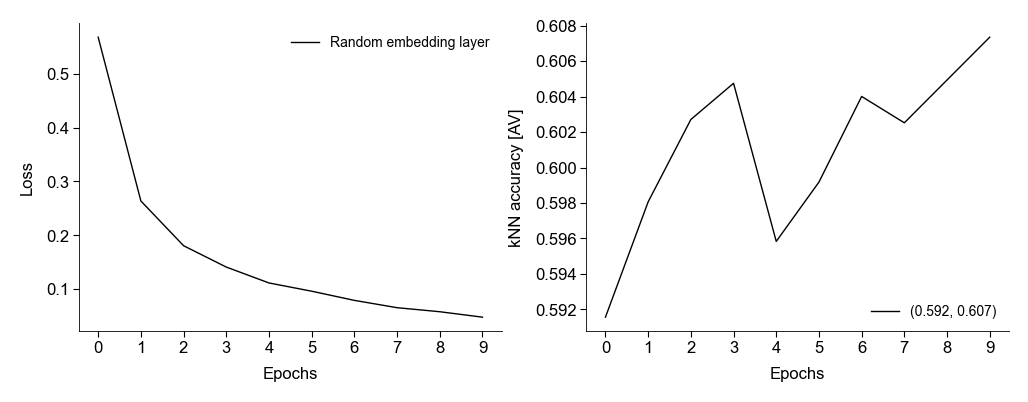

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

# plot
color = "k"  

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)

axs[1].set_xticks(np.arange(n_epochs))
# axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")


fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_training_embeddR_run_3_{dataset_name}_v1.png"
)

#### Training only on train set
10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 53.2 ms, sys: 3.64 ms, total: 56.9 ms
Wall time: 168 ms


In [ ]:
%%time
# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split_embedding_layer(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(
    variables_path / saving_path / "losses_run3_10_epochs_train_test_split",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run3_10_epochs_train_test_split",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

----------------------------
CPU times: user 47min 44s, sys: 5min 54s, total: 53min 38s
Wall time: 9min 1s


## Fine-tune SBERT (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "SBERT",
]


model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/814 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

----------------------------
CPU times: user 31min 52s, sys: 3min 4s, total: 34min 56s
Wall time: 18min 53s


In [ ]:
print(knn_accuracies)

[array([0.64863358, 0.58226436, 0.59602157])]


# Medrxiv
51 classes

## Get dataset

In [ ]:
dataset_name = "medrxiv"
dataset_path = "mteb/medrxiv-clustering-p2p"

In [ ]:
dataset = load_dataset(dataset_path)

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 17647
    })
})

## Baseline accs

### TF-IDF

In [ ]:
%%time

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(dataset["test"]["sentences"])
print(tfidf_features.shape)

(17647, 78739)
CPU times: user 2.47 s, sys: 32.7 ms, total: 2.5 s
Wall time: 2.5 s


In [ ]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# # save results
# np.save(variables_path / "updated_dataset" / "svd_data", svd_data)

peak memory: 2198.69 MiB, increment: 0.00 MiB
CPU times: user 8.59 s, sys: 208 ms, total: 8.8 s
Wall time: 8.9 s


In [ ]:
%%time
%%memit

knn_accuracies = knn_accuracy(
    [tfidf_features, svd_data, normalize(svd_data, axis=1)],
    dataset["test"]["labels"],
)
np.save(
    variables_path
    / "updated_dataset"
    / f"knn_accuracy_tfidf_svd_l2_{dataset_name}",
    knn_accuracies,
)

peak memory: 2197.59 MiB, increment: 3.94 MiB
CPU times: user 7min 25s, sys: 4.77 s, total: 7min 30s
Wall time: 16.8 s


In [ ]:
print(knn_accuracies)

[0.52011331 0.4878187  0.5286119 ]


### Models

In [ ]:
model_names = [
    "MPNet",
    "SimCSE",
    "SBERT",
    "SPECTER",
    "SciNCL",
]

model_paths = [
    "microsoft/mpnet-base",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_names[i])

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # evaluation
    model.to(device)

    ## get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        dataset["test"]["sentences"],
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    ## run knn
    knn_accuracies_baseline = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        dataset["test"]["labels"],
    )
    print(f"{model_name}: {knn_accuracies_baseline}")

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        f"updated_dataset/mteb_datasets/{dataset_name}"
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    np.save(
        variables_path / saving_path / "knn_accuracies_baseline",
        knn_accuracies_baseline,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

MPNet: [0.43512748 0.44192635 0.4368272 ]
----------------------------
Model:  SimCSE
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SimCSE: [0.47195467 0.42549575 0.44985836]
----------------------------
Model:  SBERT
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SBERT: [0.56770538 0.52294618 0.55184136]
----------------------------
CPU times: user 6min 28s, sys: 7min 9s, total: 13min 37s
Wall time: 7min 37s


## Fine-tune MPNet (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 7min 7s, sys: 6min 21s, total: 13min 29s
Wall time: 7min 3s


In [ ]:
print(knn_accuracies)

[array([0.52351275, 0.51784703, 0.50991501])]


#### Training only on train set
Only MPNet, crops

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 10min 31s, sys: 1min 29s, total: 12min 1s
Wall time: 6min 28s


In [ ]:
print(knn_accuracies)

[0.5229461756373938]


## Fine-tune MPNet (dropout)
Run 2, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2",
    knn_accuracies,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 7min 21s, sys: 6min 16s, total: 13min 37s
Wall time: 7min 4s


In [ ]:
print(knn_accuracies)

[array([0.4776204 , 0.50311615, 0.50424929])]


#### Training only on train set
Only MPNet, Dropout

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = SameSentencePairDataset(
    pd.Series(sentences_train),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run2_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 10min 31s, sys: 1min 8s, total: 11min 39s
Wall time: 6min 27s


In [ ]:
print(knn_accuracies)

[0.4776203966005666]


## Fine-tune random BERT (crops)
Run 5, crop augmentations

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run5", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5",
    knn_accuracies,
)


print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

----------------------------
CPU times: user 30min 14s, sys: 50min 36s, total: 1h 20min 50s
Wall time: 1h 3min 20s


In [ ]:
print(knn_accuracies)

[array([0.61777282, 0.61256739, 0.60252835])]


#### Training only on train set 
RandomBERT, Crops

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run5_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5_train_test_split",
    knn_accuracies,
)

Model:  random_bert
Running on device: cuda


  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

In [ ]:
print(knn_accuracies)

[0.39773371104815863, 0.41076487252124644, 0.41473087818696885, 0.426628895184136, 0.42606232294617563, 0.44079320113314446, 0.4322946175637394, 0.4368271954674221, 0.43626062322946174, 0.4396600566572238]


## Fine-tune random embedding layer (not module)

### Run 3, crop augmentation, 1 epoch

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 31.6 ms, sys: 10.2 ms, total: 41.8 ms
Wall time: 162 ms


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 16min 50s, sys: 4min 25s, total: 21min 15s
Wall time: 4min 2s


### Run 3, crop augmentation, 10 epoch

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 31.6 ms, sys: 10.2 ms, total: 41.8 ms
Wall time: 162 ms


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3_10_epochs", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_10_epochs",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 16min 50s, sys: 4min 25s, total: 21min 15s
Wall time: 4min 2s


In [ ]:
knn_accuracies = np.vstack(knn_accuracies)  

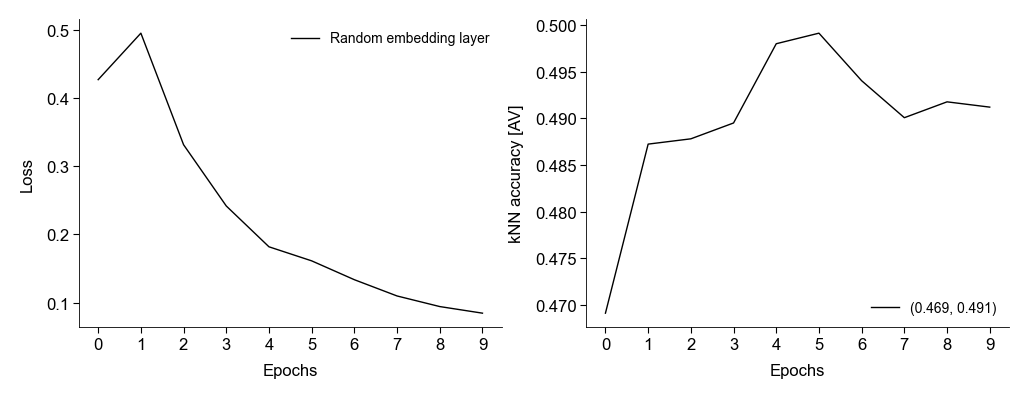

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")


# plot
color = "k"  

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)

axs[1].set_xticks(np.arange(n_epochs))
# axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")


fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embeddR_run_3_medrxiv_v1.png"
)

#### Training only on train set 
10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 49.1 ms, sys: 4.86 ms, total: 54 ms
Wall time: 169 ms


In [ ]:
%%time
# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    dataset["test"]["sentences"],
    dataset["test"]["labels"],
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split_embedding_layer(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(
    variables_path / saving_path / "losses_run3_10_epochs_train_test_split",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run3_10_epochs_train_test_split",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------
CPU times: user 17min 17s, sys: 2min 7s, total: 19min 24s
Wall time: 3min 3s


## Fine-tune SBERT (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "SBERT",
]


model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(dataset["test"]["sentences"]),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    dataset["test"]["sentences"],
    tokenizer,
    np.ones(len(dataset["test"]), dtype=bool),
    labels_acc=dataset["test"]["labels"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

----------------------------
CPU times: user 10min 50s, sys: 1min 20s, total: 12min 10s
Wall time: 6min 56s


In [ ]:
print(knn_accuracies)

[array([0.54107649, 0.50141643, 0.54220963])]


# Reddit
450 classes

## Get dataset

In [ ]:
dataset_name = "reddit"
dataset_path = "mteb/reddit-clustering-p2p"

In [ ]:
dataset = load_dataset(dataset_path)

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})

In [ ]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels = list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy()))

In [ ]:
len(sentences)

459399

## Baseline accs

### TF-IDF

In [ ]:
%%time

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(sentences)
print(tfidf_features.shape)

(459399, 320065)
CPU times: user 29.7 s, sys: 754 ms, total: 30.5 s
Wall time: 30.6 s


In [ ]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# # save results
# np.save(variables_path / "updated_dataset" / "svd_data", svd_data)

peak memory: 4605.07 MiB, increment: 698.91 MiB
CPU times: user 2min 28s, sys: 1.28 s, total: 2min 30s
Wall time: 2min 30s


In [ ]:
%%time
%%memit

knn_accuracies = knn_accuracy(
    [tfidf_features, svd_data, normalize(svd_data, axis=1)],
    labels,
)
np.save(
    variables_path
    / "updated_dataset"
    / f"knn_accuracy_tfidf_svd_l2_{dataset_name}",
    knn_accuracies,
)

peak memory: 6265.70 MiB, increment: 827.57 MiB
CPU times: user 1d 1h 32min 16s, sys: 20.1 s, total: 1d 1h 32min 36s
Wall time: 53min 12s


In [ ]:
print(knn_accuracies)

[0.19553766 0.47033087 0.49457989]


### Models

In [ ]:
model_names = [
    "MPNet",
    "SimCSE",
    "SBERT",
    "SPECTER",
    "SciNCL",
]

model_paths = [
    "microsoft/mpnet-base",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_names[i])

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # evaluation
    model.to(device)

    ## get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    ## run knn
    knn_accuracies_baseline = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels,
    )
    print(f"{model_name}: {knn_accuracies_baseline}")

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        f"updated_dataset/mteb_datasets/{dataset_name}"
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    np.save(
        variables_path / saving_path / "knn_accuracies_baseline",
        knn_accuracies_baseline,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SPECTER
Running on device: cuda


/.pyenv/versions/miniconda3-latest/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SPECTER: [0.55200261 0.5762081  0.5685677 ]
----------------------------
Model:  SciNCL
Running on device: cuda


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SciNCL: [0.57276883 0.59333914 0.59129299]
----------------------------
CPU times: user 2h 37min 50s, sys: 1h 44min 44s, total: 4h 22min 34s
Wall time: 1h 58min 6s


## Fine-tune MPNet (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 2h 38min 46s, sys: 2h 3min 37s, total: 4h 42min 24s
Wall time: 2h 23min 53s


In [ ]:
print(knn_accuracies)

[array([0.71963431, 0.71332172, 0.64860688])]


#### Training only on train set
Only MPNet, crops

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/4057 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 3h 28min 39s, sys: 22min 25s, total: 3h 51min 5s
Wall time: 2h 13min 22s


In [ ]:
print(knn_accuracies)

[0.7184153243360906]


## Fine-tune MPNet (dropout)
Run 2, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2",
    knn_accuracies,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 2h 38min 27s, sys: 2h 2min 19s, total: 4h 40min 46s
Wall time: 2h 23min 50s


In [ ]:
print(knn_accuracies)

[array([0.57799303, 0.644101  , 0.59044406])]


#### Training only on train set
Only MPNet, Dropout, eval only for labels secondary

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = SameSentencePairDataset(
    pd.Series(sentences_train),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run2_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/4057 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 3h 28min 58s, sys: 23min 51s, total: 3h 52min 49s
Wall time: 2h 13min 32s


In [ ]:
print(knn_accuracies)

[0.5957553330430997]


## Fine-tune random BERT (crops)
Run 5, crop augmentations

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run5", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5",
    knn_accuracies,
)


print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

In [ ]:
print(knn_accuracies)

[array([0.43744014, 0.43920331, 0.35953418]), array([0.51343056, 0.50361341, 0.43702656]), array([0.5526121 , 0.53615586, 0.53032216]), array([0.57046147, 0.55794515, 0.55439704]), array([0.58313017, 0.56743579, 0.57154985]), array([0.59767088, 0.57688289, 0.58402264]), array([0.60635612, 0.59164127, 0.59730083]), array([0.61251633, 0.59212016, 0.59978232]), array([0.61961254, 0.59760557, 0.60459295]), array([0.61819765, 0.59786678, 0.60430997])]


#### Training only on train set 
RandomBERT, Crops

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run5_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5_train_test_split",
    knn_accuracies,
)

Model:  random_bert
Running on device: cuda


  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 23h 23min 58s, sys: 2h 33min 5s, total: 1d 1h 57min 3s
Wall time: 18h 19min 25s


In [ ]:
print(knn_accuracies)

[0.4498476273400087, 0.49029168480626906, 0.5272747061384414, 0.5448628646060079, 0.5565302568567697, 0.571767522855899, 0.5833043099695254, 0.5887679582063561, 0.5914018284719199, 0.5937962559860688]


## Fine-tune random embedding layer (not module)

### Run 3, crop augmentations 1 epoch

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 59.7 ms, sys: 40.8 ms, total: 100 ms
Wall time: 227 ms


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

----------------------------
CPU times: user 1h 18min 17s, sys: 14min 21s, total: 1h 32min 38s
Wall time: 8min 58s


### Run 3, crop augmentations 10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 51.4 ms, sys: 15 ms, total: 66.4 ms
Wall time: 200 ms


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3_10_epochs", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_10_epochs",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

----------------------------
CPU times: user 11h 17min 28s, sys: 1h 25min 18s, total: 12h 42min 47s
Wall time: 1h 6min 45s


In [ ]:
knn_accuracies = np.vstack(knn_accuracies) 

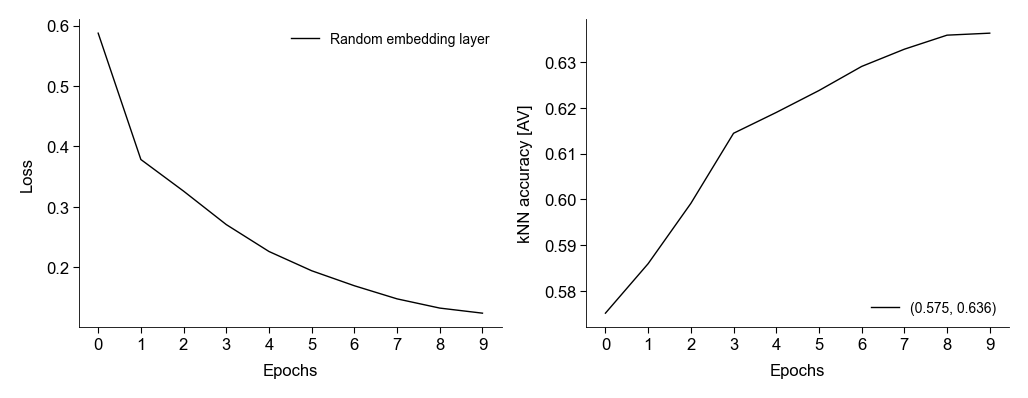

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

# plot
color = "k"  

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)

axs[1].set_xticks(np.arange(n_epochs))
# axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")


fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_training_embeddR_run_3_{dataset_name}_v1.png"
)

#### Training only on train set 
10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 61.4 ms, sys: 63.1 ms, total: 125 ms
Wall time: 258 ms


In [ ]:
%%time
# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split_embedding_layer(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(
    variables_path / saving_path / "losses_run3_10_epochs_train_test_split",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run3_10_epochs_train_test_split",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/2029 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

----------------------------
CPU times: user 55min 56s, sys: 12min 17s, total: 1h 8min 13s
Wall time: 17min 15s


In [ ]:
print(knn_accuracies)

[0.5016978667827601]


## Fine-tune SBERT (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "SBERT",
]


model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/4505 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

----------------------------
CPU times: user 4h 5min 4s, sys: 24min 40s, total: 4h 29min 44s
Wall time: 2h 21min 56s


In [ ]:
print(knn_accuracies)

[array([0.75339573, 0.76123204, 0.72357423])]


# Stackexchange

## Get dataset

In [ ]:
dataset_name = "stackexchange"
dataset_path = "mteb/stackexchange-clustering-p2p"

In [ ]:
dataset = load_dataset(dataset_path)

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})

In [ ]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels = list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy()))

In [ ]:
len(sentences)

75000

## Baseline accs

### TF-IDF

In [ ]:
%%time

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(sentences)
print(tfidf_features.shape)

(75000, 120133)
CPU times: user 5.92 s, sys: 226 ms, total: 6.15 s
Wall time: 6.15 s


In [ ]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# # save results
# np.save(variables_path / "updated_dataset" / "svd_data", svd_data)

peak memory: 5883.33 MiB, increment: 174.39 MiB
CPU times: user 32.9 s, sys: 480 ms, total: 33.4 s
Wall time: 33.5 s


In [ ]:
%%time
%%memit

knn_accuracies = knn_accuracy(
    [tfidf_features, svd_data, normalize(svd_data, axis=1)],
    labels,
)
np.save(
    variables_path
    / "updated_dataset"
    / f"knn_accuracy_tfidf_svd_l2_{dataset_name}",
    knn_accuracies,
)

peak memory: 5933.61 MiB, increment: 50.39 MiB
CPU times: user 50min 44s, sys: 5.82 s, total: 50min 50s
Wall time: 1min 52s


In [ ]:
print(knn_accuracies)

[0.47533333 0.45866667 0.45613333]


### Models

In [ ]:
model_names = [
    "MPNet",
    "SimCSE",
    "SBERT",
    "SPECTER",
    "SciNCL",
]

model_paths = [
    "microsoft/mpnet-base",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_names[i])

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # evaluation
    model.to(device)

    ## get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    ## run knn
    knn_accuracies_baseline = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels,
    )
    print(f"{model_name}: {knn_accuracies_baseline}")

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        f"updated_dataset/mteb_datasets/{dataset_name}"
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    np.save(
        variables_path / saving_path / "knn_accuracies_baseline",
        knn_accuracies_baseline,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SPECTER
Running on device: cuda


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SPECTER: [0.41453333 0.4552     0.4464    ]
----------------------------
Model:  SciNCL
Running on device: cuda


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SciNCL: [0.42933333 0.47626667 0.46786667]
----------------------------
CPU times: user 12min 44s, sys: 17min 42s, total: 30min 26s
Wall time: 19min 10s


## Fine-tune MPNet (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
print(knn_accuracies)

[array([0.45613333, 0.4596    , 0.4144    ])]


#### Training only on train set
Only MPNet, crops

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 34min 9s, sys: 4min 36s, total: 38min 45s
Wall time: 24min 33s


In [ ]:
print(knn_accuracies)

[0.4512]


## Fine-tune MPNet (dropout)
Run 2, crop augmentations

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2",
    knn_accuracies,
)


print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 21min 17s, sys: 22min 49s, total: 44min 6s
Wall time: 26min 32s


In [ ]:
print(knn_accuracies)

[array([0.41573333, 0.4216    , 0.41053333])]


#### Training only on train set
Only MPNet, Dropout, eval only for labels secondary

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = SameSentencePairDataset(
    pd.Series(sentences_train),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run2_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run2_train_test_split",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 33min 57s, sys: 5min 1s, total: 38min 59s
Wall time: 24min 31s


In [ ]:
print(knn_accuracies)

[0.4126666666666667]


## Fine-tune random BERT (crops)
Run 5, crop augmentations

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run5", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5",
    knn_accuracies,
)


print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

In [ ]:
print(knn_accuracies)

[array([0.4088    , 0.41453333, 0.32093333])]


#### Training only on train set
RandomBERT, Crops

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
model_name = "random_bert"

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run5_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run5_train_test_split",
    knn_accuracies,
)

Model:  random_bert
Running on device: cuda


  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 4h 12s, sys: 29min 55s, total: 4h 30min 7s
Wall time: 3h 27min 46s


In [ ]:
print(knn_accuracies)

[0.4136, 0.4232, 0.4328, 0.43733333333333335, 0.4436, 0.44666666666666666, 0.4454666666666667, 0.4461333333333333, 0.4532, 0.4518666666666667]


## Fine-tune random embedding layer (not module)

### Run 3, crop augmentations, 1 epoch

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 41.9 ms, sys: 9 ms, total: 50.9 ms
Wall time: 163 ms


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

----------------------------
CPU times: user 8min 56s, sys: 2min 45s, total: 11min 41s
Wall time: 1min 44s


### Run 3, crop augmentations, 10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 47.5 ms, sys: 14.8 ms, total: 62.3 ms
Wall time: 177 ms


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run3_10_epochs", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3_10_epochs",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

----------------------------
CPU times: user 1h 6min 33s, sys: 14min 53s, total: 1h 21min 26s
Wall time: 11min 15s


In [ ]:
knn_accuracies = np.vstack(knn_accuracies)  

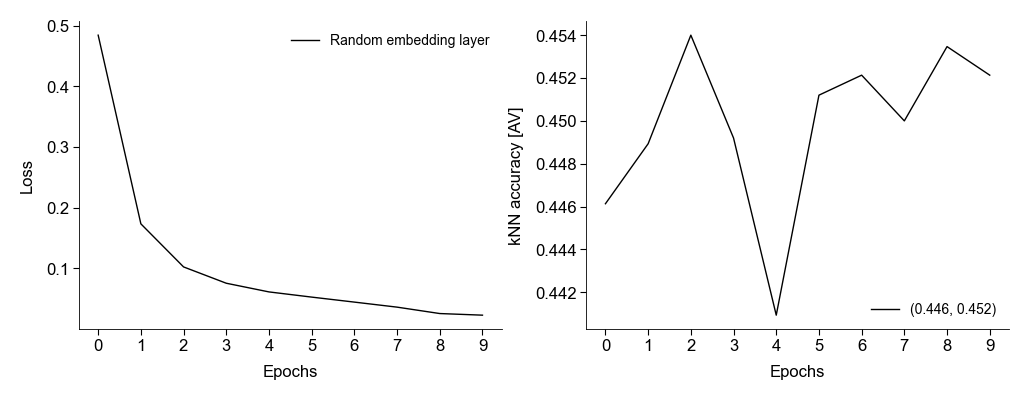

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

# plot
color = "k" 

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)

axs[1].set_xticks(np.arange(n_epochs))
# axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")


fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_training_embeddR_run_3_{dataset_name}_v1.png"
)

#### Training only on train set 
10 epochs

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 49.8 ms, sys: 4.85 ms, total: 54.7 ms
Wall time: 168 ms


In [ ]:
%%time
# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
) = train_test_split(
    sentences,
    labels,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences_train), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split_embedding_layer(
    model,
    training_loader,
    device,
    tokenizer,
    sentences_train,
    sentences_test,
    labels_train,
    labels_test,
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(
    variables_path / saving_path / "losses_run3_10_epochs_train_test_split",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run3_10_epochs_train_test_split",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

----------------------------
CPU times: user 50min 52s, sys: 11min 42s, total: 1h 2min 34s
Wall time: 10min 12s


## Fine-tune SBERT (crops)
Run 1, crop augmentations

In [ ]:
model_names = [
    "SBERT",
]


model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    sentences,
    tokenizer,
    np.ones(len(sentences), dtype=bool),
    labels_acc=labels,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    f"updated_dataset/mteb_datasets/{dataset_name}"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)


print("----------------------------")

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

----------------------------
CPU times: user 37min 19s, sys: 4min 41s, total: 42min
Wall time: 26min 6s


In [ ]:
print(knn_accuracies)

[array([0.51      , 0.5036    , 0.47773333])]
